In [1]:
 !python -m pip install --upgrade pip

 !pip install supervision==0.3.0

 !pip install transformers

 !pip install pytorch-lightning

 !pip install timm

 !pip install cython

 !pip install pycocotools

!pip install scipy

!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 41.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
import torch
torch.__version__

'2.5.1+cu121'

In [3]:
import supervision as sv
import transformers

sv.__version__ , transformers.__version__

('0.3.0', '4.46.3')

In [4]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.4.0


In [5]:
import os
import torchvision
from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

dataset = '/content/drive/MyDrive/Colab Notebooks/Dataset'

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=2.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 326


Image #42


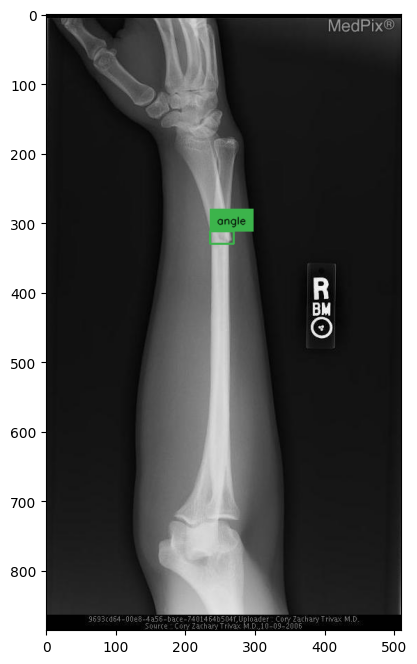

In [6]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (8, 8))

In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [8]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):

        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

KeyboardInterrupt: 

In [9]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 200

trainer = Trainer( max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


NameError: name 'model' is not defined

In [10]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/custom-model'

In [11]:
import torch

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


In [12]:
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

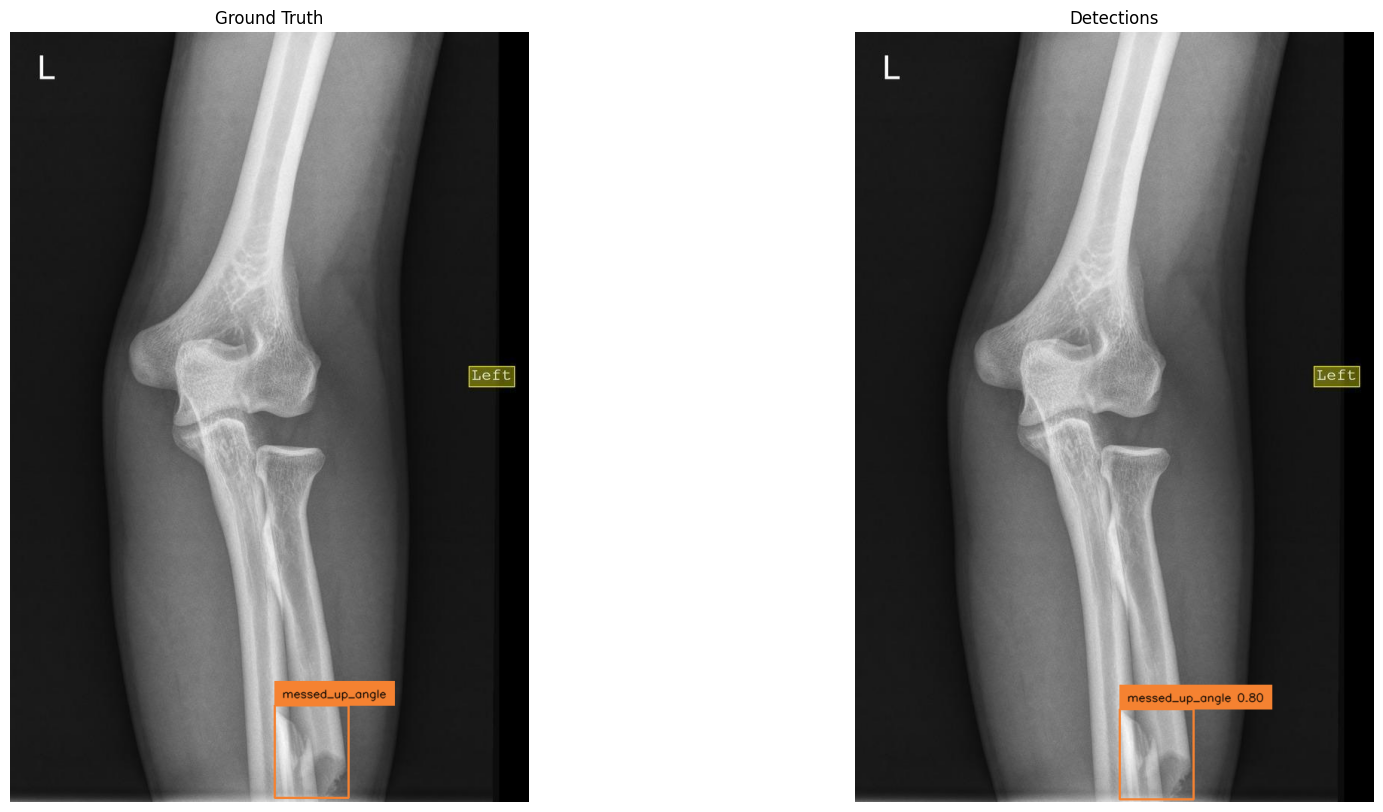

In [20]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# utils
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}
box_annotator = sv.BoxAnnotator()

# Select a random image from the training dataset
random_index = random.randint(0, len(TRAIN_DATASET) - 1)
image, target = TRAIN_DATASET[random_index]

# Get the image path and annotations
image_id = TRAIN_DATASET.ids[random_index]
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]

# Load the image using OpenCV
image_cv2 = cv2.imread(image_path)

if image_cv2 is not None:
    # Annotate ground truth
    detections_gt = sv.Detections.from_coco_annotations(coco_annotation=annotations)
    labels_gt = [f"{id2label[class_id]}" for _, _, class_id, _ in detections_gt]
    frame_ground_truth = box_annotator.annotate(scene=image_cv2.copy(), detections=detections_gt, labels=labels_gt)

    # Perform prediction
    with torch.no_grad():
        inputs = image_processor(images=image_cv2, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)

        # Post-process
        target_sizes = torch.tensor([image_cv2.shape[:2]]).to(DEVICE)
        results = image_processor.post_process_object_detection(
            outputs=outputs, threshold=0.5, target_sizes=target_sizes
        )[0]

        detections_pred = sv.Detections.from_transformers(transformers_results=results)
        labels_pred = [f"{id2label[class_id]} {confidence:.2f}"
                       for _, confidence, class_id, _ in detections_pred]
        frame_detections = box_annotator.annotate(scene=image_cv2.copy(), detections=detections_pred, labels=labels_pred)

    # Visualize
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title('Ground Truth')

    axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    axs[1].set_title('Detections')

    plt.show()
else:
    print(f"Error: Unable to load image from path: {image_path}")

In [ ]:
 from google.colab.patches import cv2_imshow

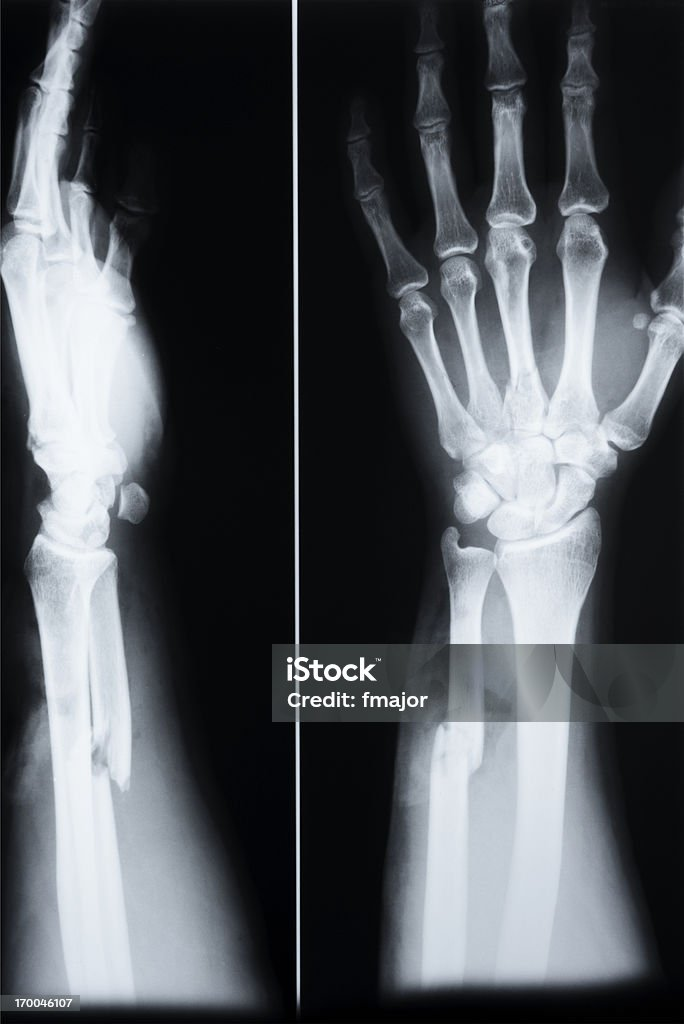

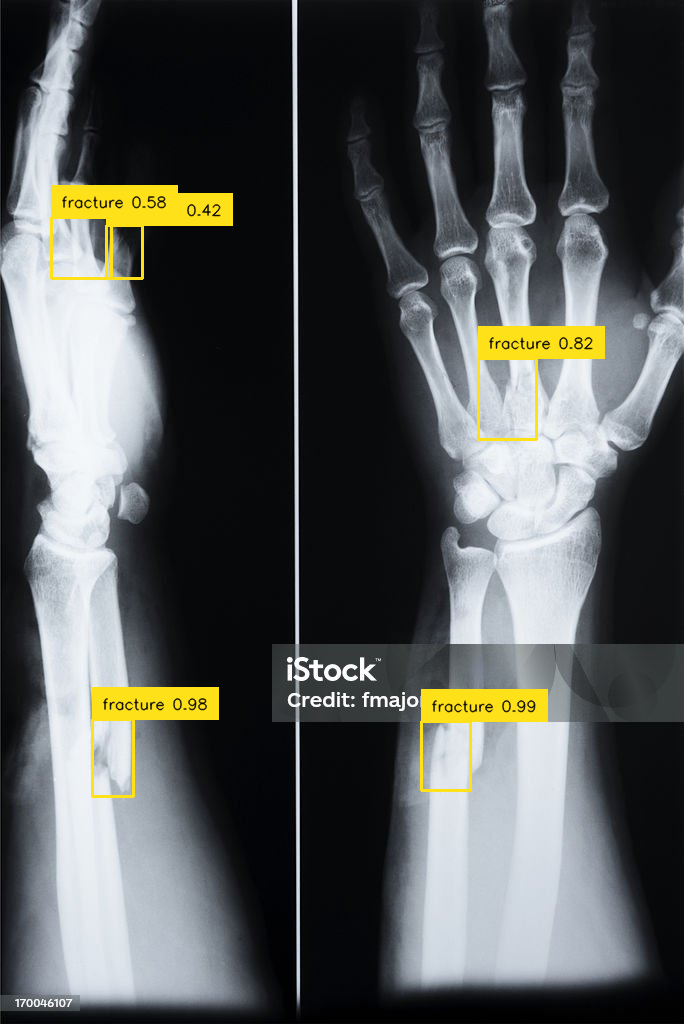

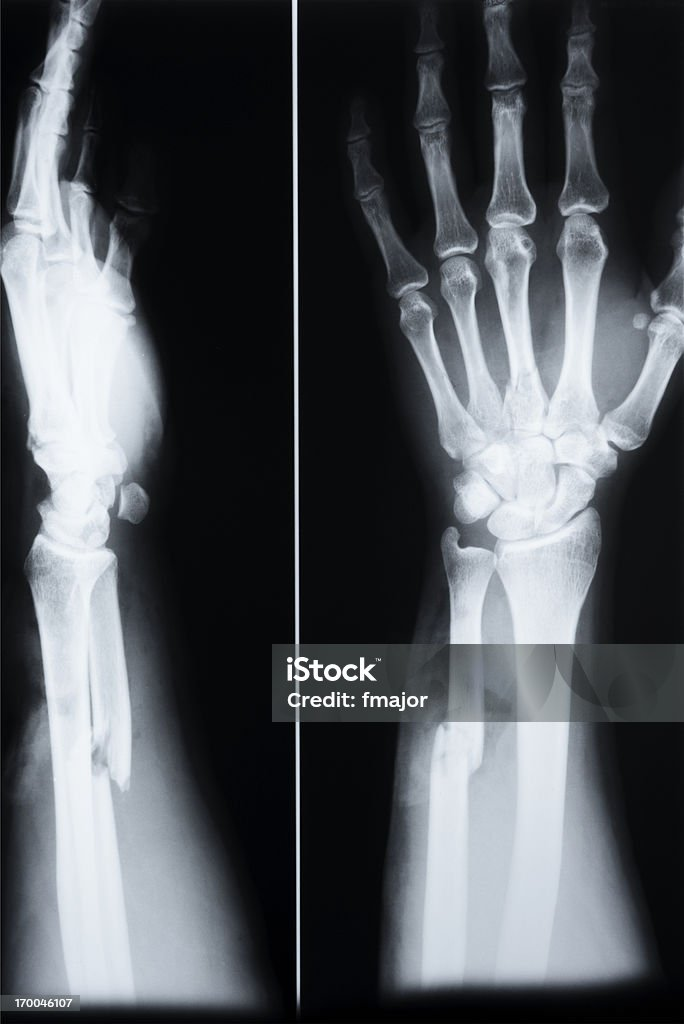

In [ ]:
box_annotator = sv.BoxAnnotator()
image_path = '/content/drive/MyDrive/nilesh frac.jpg'
image = cv2.imread(image_path)
cv2_imshow(image)

CONFIDENCE_TRESHOLD  = 0.35
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt").to(DEVICE)
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, threshold=CONFIDENCE_TRESHOLD, target_sizes=target_sizes )[0]

detections = sv.Detections.from_transformers(transformers_results=results)
labels = [f"{id2label[class_id]} {confidence:.2f}"
          for _, confidence, class_id, _ in detections]
image_with_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

cv2_imshow(image_with_detections)
cv2_imshow(image)



In [ ]:
!pip freeze


absl-py==1.4.0
accelerate==1.1.1
aiohappyeyeballs==2.4.3
aiohttp==3.11.2
aiosignal==1.3.1
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.6
astropy-iers-data==0.2024.11.18.0.35.2
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.27.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.1
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.0
CacheControl==0.14.1
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.87
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.30.5
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.

In [ ]:
!python -v

import _frozen_importlib # frozen
import _imp # builtin
import '_thread' # <class '_frozen_importlib.BuiltinImporter'>
import '_warnings' # <class '_frozen_importlib.BuiltinImporter'>
import '_weakref' # <class '_frozen_importlib.BuiltinImporter'>
import '_io' # <class '_frozen_importlib.BuiltinImporter'>
import 'marshal' # <class '_frozen_importlib.BuiltinImporter'>
import 'posix' # <class '_frozen_importlib.BuiltinImporter'>
import '_frozen_importlib_external' # <class '_frozen_importlib.FrozenImporter'>
# installing zipimport hook
import 'time' # <class '_frozen_importlib.BuiltinImporter'>
import 'zipimport' # <class '_frozen_importlib.FrozenImporter'>
# installed zipimport hook
# /usr/lib/python3.10/encodings/__pycache__/__init__.cpython-310.pyc matches /usr/lib/python3.10/encodings/__init__.py
# code object from '/usr/lib/python3.10/encodings/__pycache__/__init__.cpython-310.pyc'
# /usr/lib/python3.10/__pycache__/codecs.cpython-310.pyc matches /usr/lib/python3.10/codecs.py
# code 

In [ ]:
!python --version

Python 3.10.12
